In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
from scipy.stats import entropy

In [3]:
root_dir = "/content/drive/MyDrive/Mi_FFI/CalibracionBienOrganizado"

In [4]:
ruta_toalla = "/content/drive/MyDrive/Mi_FFI/fondo_toalla.jpeg"
ruta_carpaleta = "/content/drive/MyDrive/Mi_FFI/fondo_carne_paleta.png"
# Ruta de la carpeta que contiene las imágenes
path = root_dir+"/pocas_imagenes"

In [5]:
def create_model(ruta_toalla,ruta_carpaleta):
    """
    Entrenar un modelo RandomForestClassifier para distinguir la paleta y la carne del fondo
    Returns a RandomForestClassifier model trained on the 'toalla' and 'carne_paleta' images
    """
    # Leer imágenes
    img_toalla = cv2.imread(ruta_toalla)
    img_carpal = cv2.imread(ruta_carpaleta)

    percentage = 0.10
    # Vectorizarlas
    nrows, ncols, nch = img_toalla.shape
    Xtoalla = np.reshape(img_toalla, (nrows*ncols, 3))

    ntoalla = len(Xtoalla)
    idx = np.random.permutation(ntoalla)[:int(ntoalla*percentage)]
    Xtoalla = Xtoalla[idx, :]

    Ytoalla = np.ones(int(ntoalla*percentage))

    nrows, ncols, nch = img_carpal.shape
    Xcarpal = np.reshape(img_carpal, (nrows*ncols, 3))

    ncarpal = len(Xcarpal)
    idx = np.random.permutation(ncarpal)[:int(ncarpal*percentage)]
    Xcarpal = Xcarpal[idx, :]

    Ycarpal = np.zeros(int(ncarpal*percentage))

    # Valores de entrenamiento
    X = np.concatenate((Xtoalla, Xcarpal), axis=0)
    Y = np.concatenate((Ytoalla, Ycarpal), axis=0)

    # Generar el clasificador de color
    model = RandomForestClassifier()
    model.fit(X, Y)
    return model


In [6]:
kernel = np.ones((29, 29), np.uint8)


def selectPalette(img_path,scale_factor=0.3,file_path=None):
    """
    Detect rectangles in the image and selects the subimage matching a color palette
    Returns the subimage of the palette found
    """

    # Leer la imagen y redimensionarla al 30%
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    h,w = img.shape[0:2]
    img = cv2.resize(img,(int(w*scale_factor),int(h*scale_factor)))
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Vectorizar la imagen
    nrows,ncols,nch = img.shape
    Ximg = np.reshape(img,(nrows*ncols,nch))
    
    # Obtener las salidas del clasificador
    yimg = model.predict(Ximg) # Nota: debe ser imagen BGR
    yimg = np.reshape(yimg,(nrows,ncols))
    yimg = yimg*255
    
    # Pasarlo a entero
    yimg = yimg.astype("uint8")
    
    # Reducir el ruido a la imagen
    ker = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(yimg, cv2.MORPH_DILATE, ker)
    ker = np.ones((25, 25), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, ker)

    # Buscar los posibles rectángulos
    countours, hierarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = [cv2.boundingRect(countour) for countour in countours]
    copy = img_rgb.copy()

    max_entropy = 0
    paleta = None

    for i,rect in enumerate(rectangles):
        # Skip the first rectangle because it is the whole image
        if i == 0:
            continue

        if rect[2] > 50 and rect[3] > 50:
            img_rgbn = img_rgb[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
            imgn_h = cv2.cvtColor(img_rgbn,cv2.COLOR_RGB2HSV)[:,:,0].flatten()
            imgn_s = cv2.cvtColor(img_rgbn,cv2.COLOR_RGB2HSV)[:,:,1].flatten()
            imgn_v = cv2.cvtColor(img_rgbn,cv2.COLOR_RGB2HSV)[:,:,2].flatten()

            imgn_h = imgn_h[np.logical_and(imgn_s > 100,imgn_v > 100)]
            hue_hist = np.histogram(imgn_h,bins=10,range=[0,180])[0]

            # print(hue_hist)
            # print(np.sum(hue_hist))
            hue_hist = hue_hist / np.sum(hue_hist)

            myentropy = entropy(hue_hist)
            if  myentropy > max_entropy:
                max_entropy = myentropy
                paleta = img_rgbn

    return paleta


## Ejecucion

In [7]:
# Obtener el modelo de clasificacion
model = create_model(ruta_toalla,ruta_carpaleta)

In [8]:
img_path = "/content/drive/MyDrive/Mi_FFI/CalibracionBienOrganizado/pocas_imagenes/20210906_S01_10_c.JPG"
img = cv2.imread(img_path,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# Ejecutar el proceso de enmascaramiento y deteccion de rectangulos
nueva_paleta = selectPalette(img_path,scale_factor=0.3,file_path=img_path)

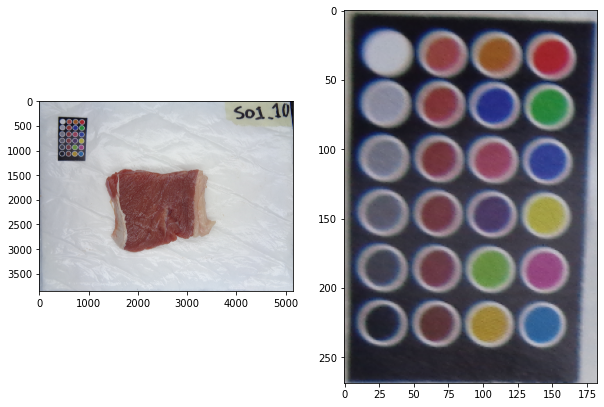

In [9]:
# Mostrar el resultado
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(nueva_paleta)
plt.show()

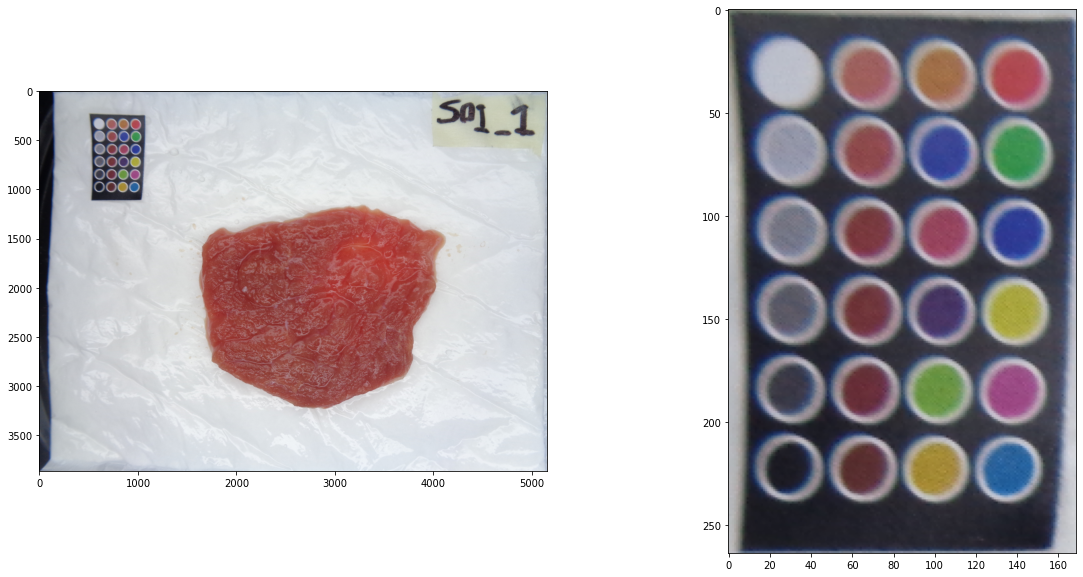

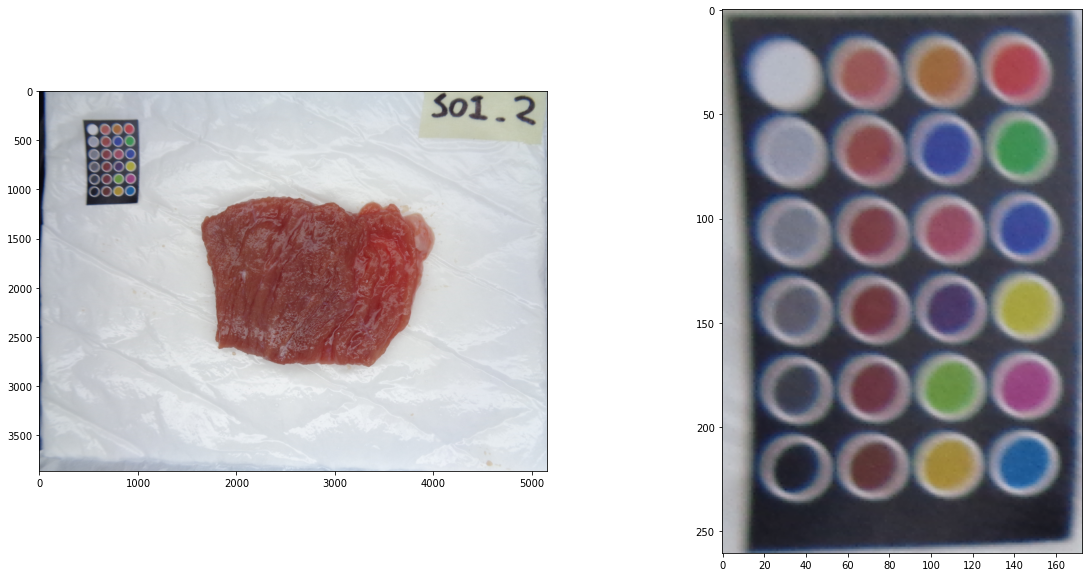

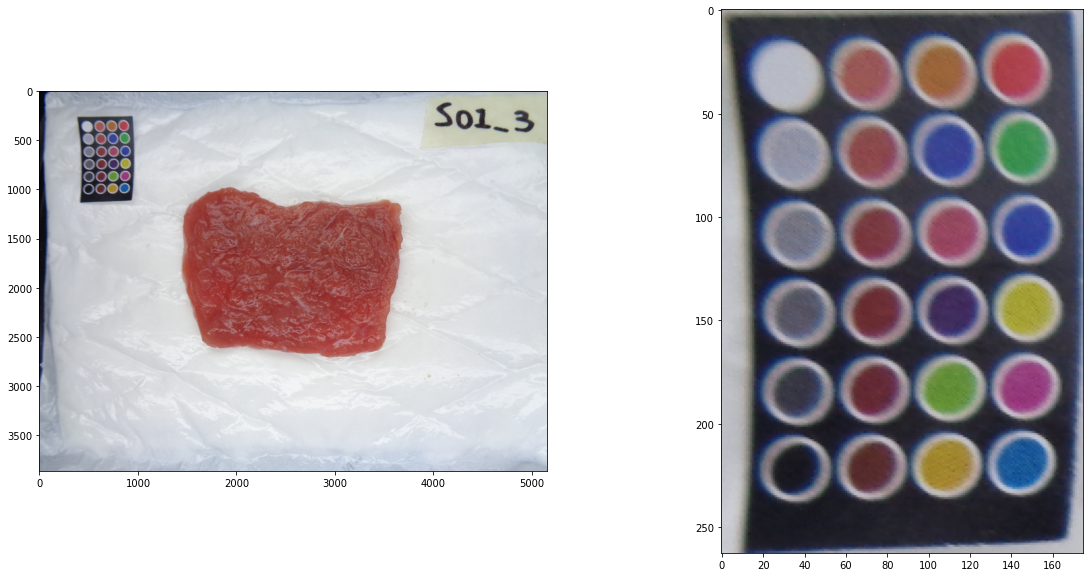

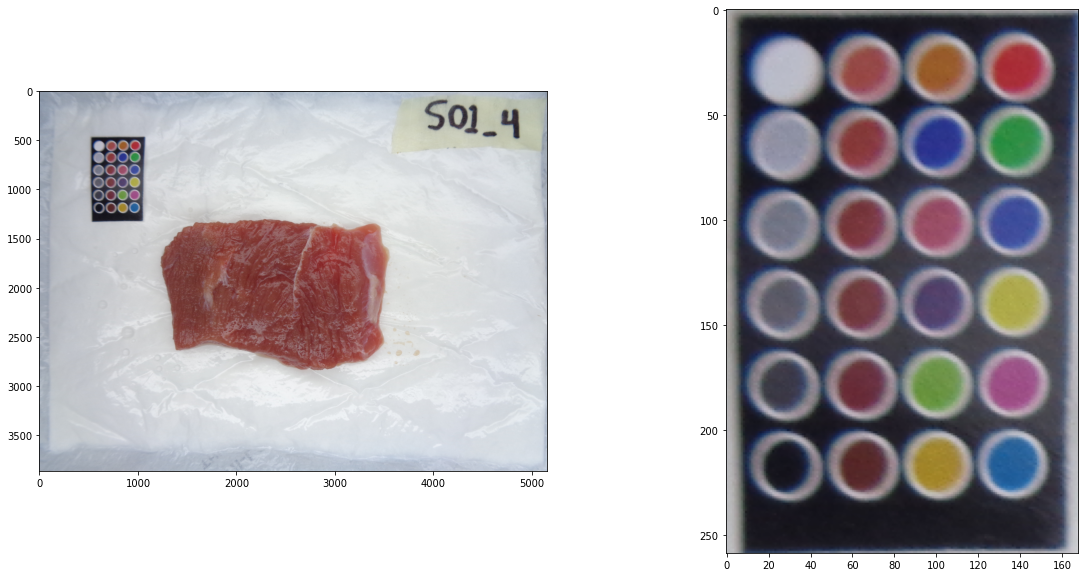

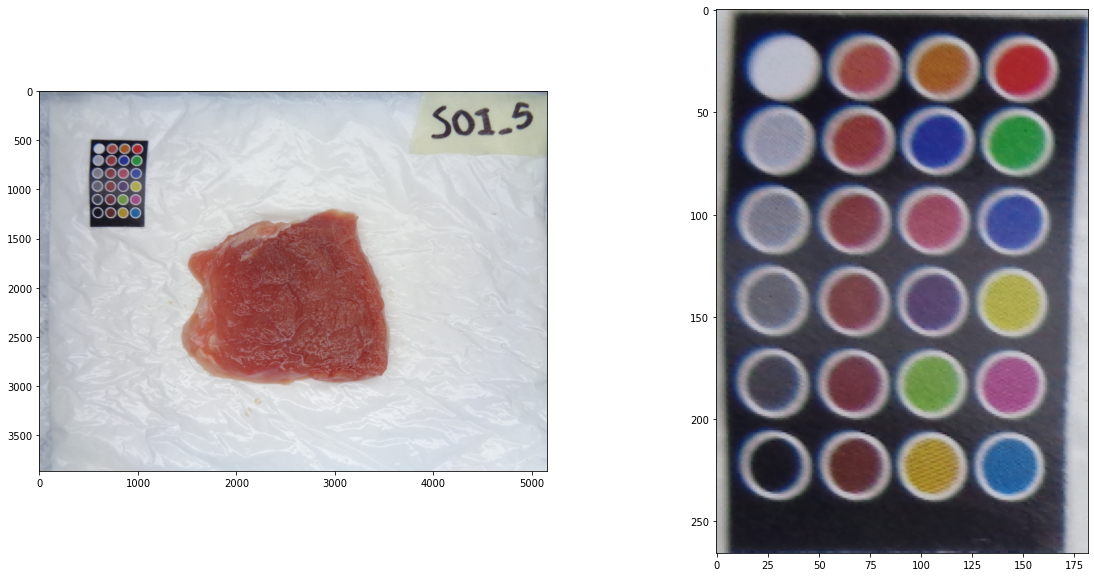

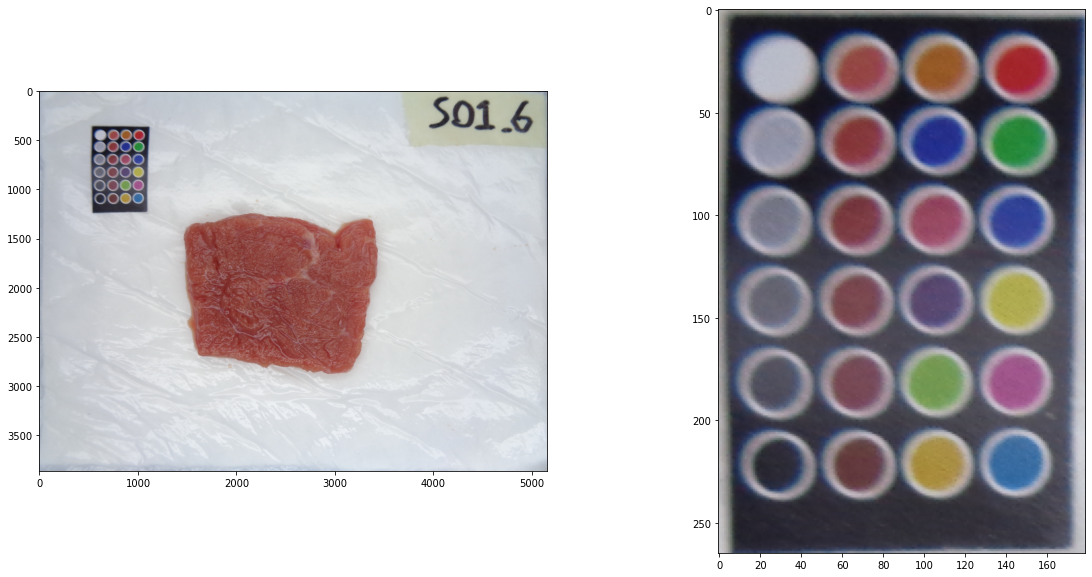

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


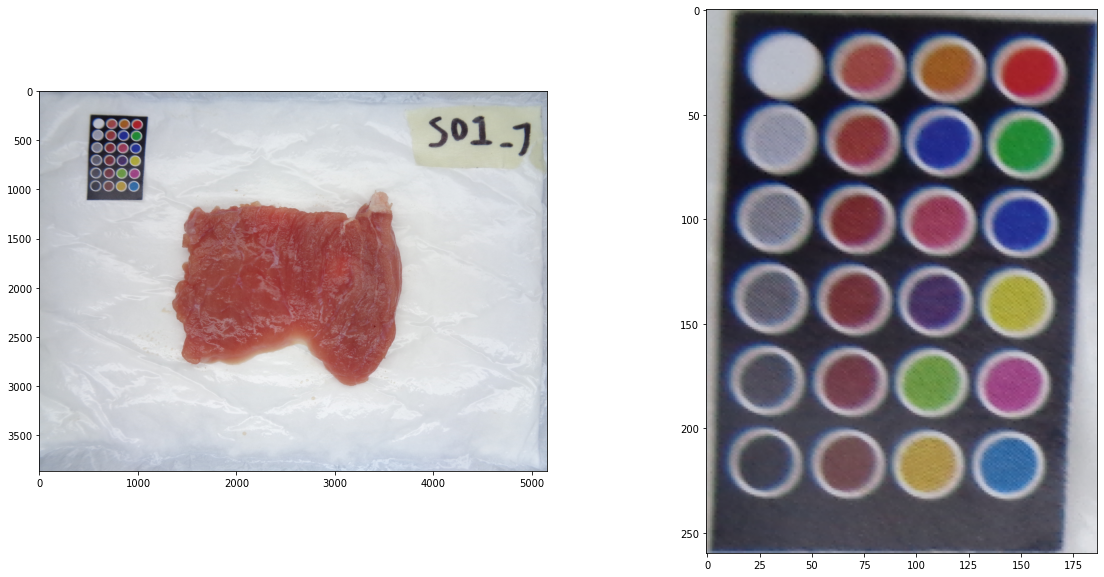

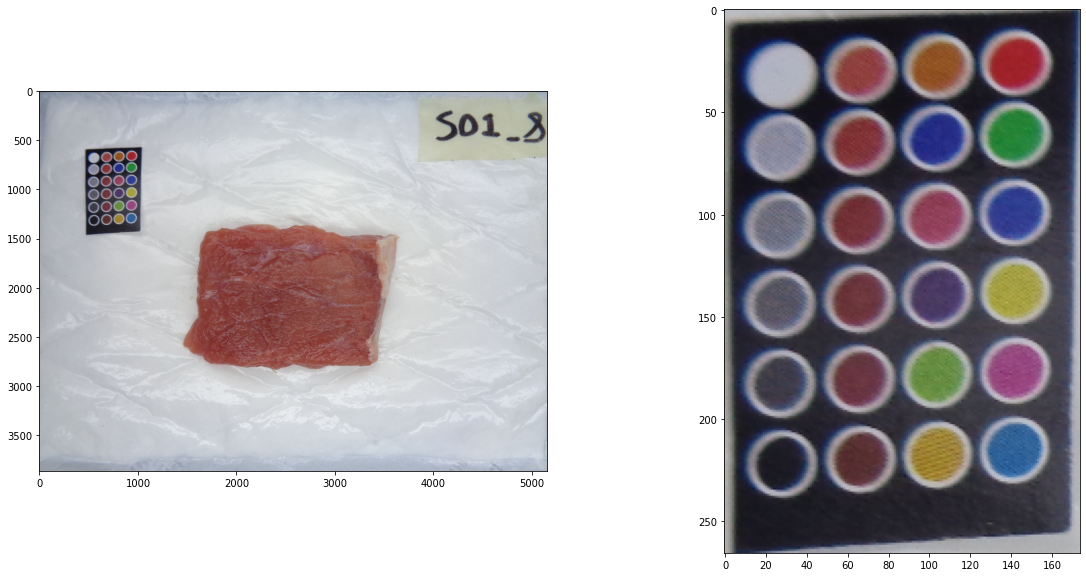

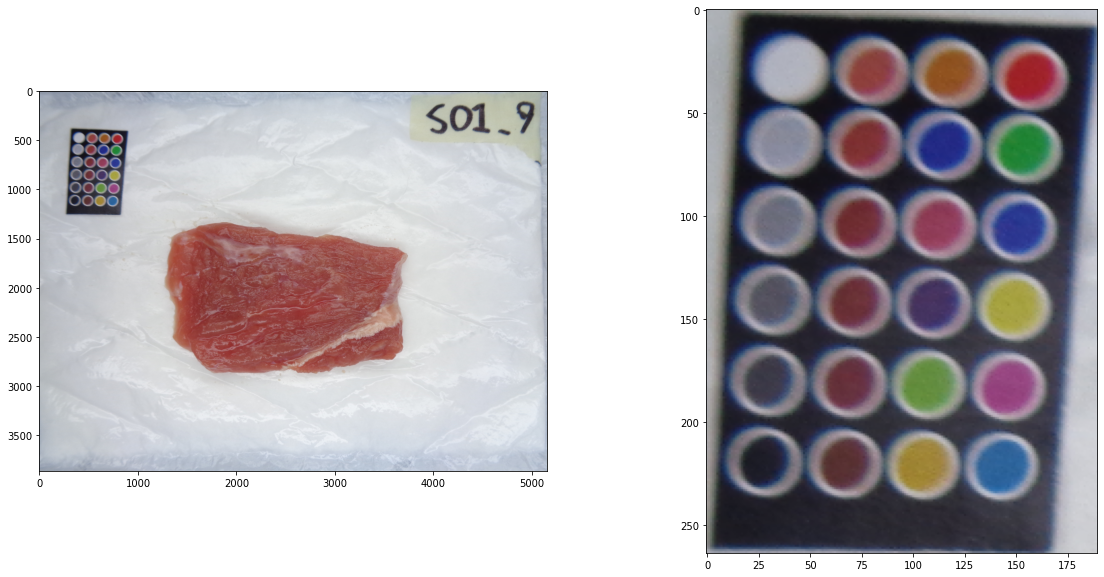

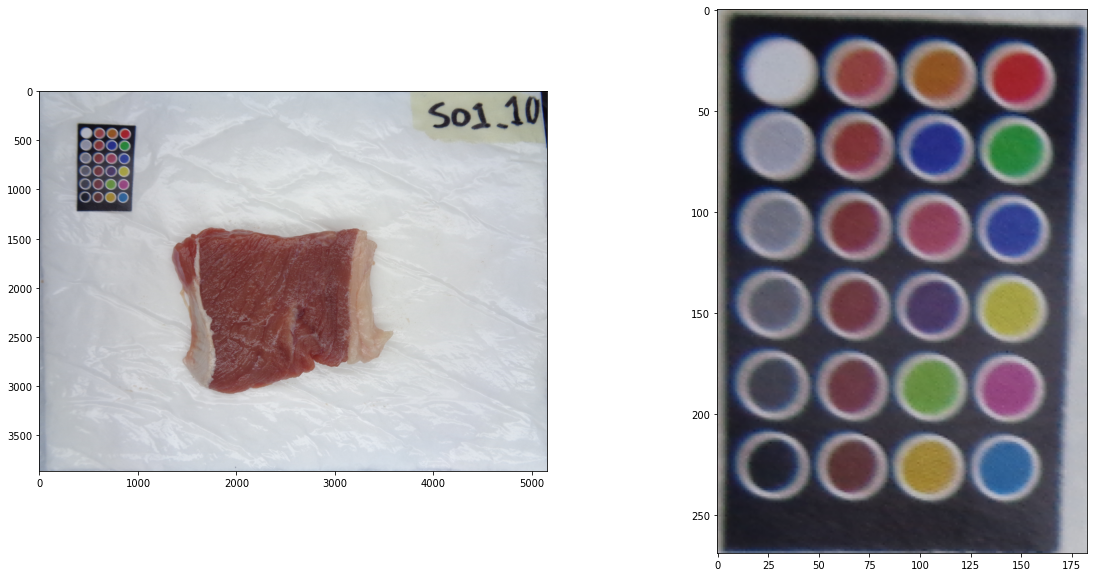

In [11]:
# Ruta de la carpeta que tiene las imágenes
path = root_dir+"/pocas_imagenes"
if not os.path.exists(root_dir+"/nuevas_paletas"):
    os.mkdir(root_dir+"/nuevas_paletas")

for entry in os.listdir(path):
    if os.path.isfile(path+'/'+entry):
        img_path = path+'/'+entry
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        nueva_paleta = selectPalette(img_path,scale_factor=0.3,file_path=img_path)
        cv2.imwrite(root_dir+"/nuevas_paletas/"+entry,cv2.cvtColor(nueva_paleta,cv2.COLOR_BGR2RGB))

        plt.figure(figsize=(20, 10))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.imshow(nueva_paleta)
        plt.show()


                